# Inference

The purpose of this notebook is to allow for evaluation/sampling with a trained NF model

## Setup

In [ ]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output
import time

In [ ]:
from reco import process_data, create_dataloader, prepare_data_for_nn, create_dataloader

In [ ]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load data from .pt file (created by preprocess.py)

## Neural Spline Flow

In [4]:
# Define flows
K = 1

latent_size = 1
hidden_units = 100
hidden_layers = 6
context_size = 4
num_context = 4

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


In [6]:
model.load("models/July_16/run_2_1flows_6hl_100hu_2000bs.pth")

In [7]:
# test_data = torch.load("data/test/July_12/full_test_data_run_1_8flows_4hl_100hu_4000bs.pt")

### Evaluation

In [8]:
# device = 'cpu'

In [9]:
model = model.to(device)

In [10]:
up_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_11.edm4hep.root:events"
data = process_data(up_path)

In [11]:
features, metadata = prepare_data_for_nn(data)
print("Features shape:", features.shape)
print("Metadata shape:", metadata.shape)

# Create DataLoader
batch_size = 1000000
dataloader = create_dataloader(features, metadata, batch_size)

Features shape: (72494710, 4)
Metadata shape: (72494710, 3)


### Resampling inference with dataloader

In [12]:

# min_time = 0
# samples = torch.empty(features.shape[0],device = device)
# it = 0
# begin_time = time.time()
# for batch_features, batch_metadata in dataloader:
#     begin = batch_size * it
#     end = batch_size * (it + 1)
#     # Initialize a mask for valid samples
#     batch_features = batch_features.to(device)
#     valid_samples = torch.zeros(batch_features.shape[0], dtype=torch.bool,device = device)
#     batch_samples = torch.empty(batch_features.shape[0],device = device)
    
#     while not valid_samples.all():
#         # Generate samples for the invalid positions
#         new_samples = model.sample(num_samples=(~valid_samples).sum(), context=batch_features[~valid_samples])[0].squeeze(1)
        
#         # Update the samples and the valid_samples mask
#         batch_samples[~valid_samples] = new_samples
#         valid_samples = batch_samples >= min_time
    
#     samples[begin:end] = batch_samples
#     it += 1
#     if(it >= 0):
#         break
# end_time = time.time()
# samples_cpu = samples.cpu()

### No resampling

In [13]:

min_time = 0
samples = torch.empty(features.shape[0],device = 'cpu')
it = 0
begin_time = time.time()
for batch_features, batch_metadata in dataloader:
    clear_output(wait=True)
    print(f"Starting batch #{it} out of {72494710 // batch_size} | {(time.time() - begin_time)} seconds elapsed")
    begin = batch_size * it
    end = batch_size * (it + 1)
    # Initialize a mask for valid samples
    batch_features = batch_features.to(device)
    batch_samples = torch.empty(batch_features.shape[0],device = device)
    samples[begin:end] = model.sample(num_samples=batch_features.shape[0], context=batch_features)[0].cpu().detach().squeeze(1)
    del batch_samples
    del batch_features
    it += 1
end_time = time.time()
samples_cpu = samples.cpu()

Starting batch #72 out of 72 | 843.9511663913727 seconds elapsed


In [14]:
# delta_t = 1209
delta_t = end_time - begin_time

In [15]:
print(f"Sampling {end} times took {(delta_t)} seconds\n rate: {end / (delta_t)} samples/second")

Sampling 73000000 times took 844.0554392337799 seconds
 rate: 86487.20997079082 samples/second



on gpu - 3500 samples/second with no resampling w/20k batch size

on cpu - 1400 samples/second no resampling w/20k batch size 

on cpu - 1136 samples/second no resampling w/10k batch size

on cpu - 2179 samples/second no resampling w/40k batch size

on gpu - 212 samples/second w resampling

on gpu - 3200 samples/second no resampling w/40k batch size

on gpu - 12000 samples/second no resampling w/80k batch size

on gpu - 5000 samples/second no resampling w/40k batch size

on gpu - 40k samples/second no resampling w/500k batch size

on gpu - 40k samples/second no resampling w/700k batch size

on gpu - 2 flow model - 73k samples/second no resampling w/500k batch size

on gpu - 2 flow model - 74k samples/second no resampling w/1m batch size

on gpu - 1 flow model - 100k samples/second w 2m batch size (july 16 run 1)

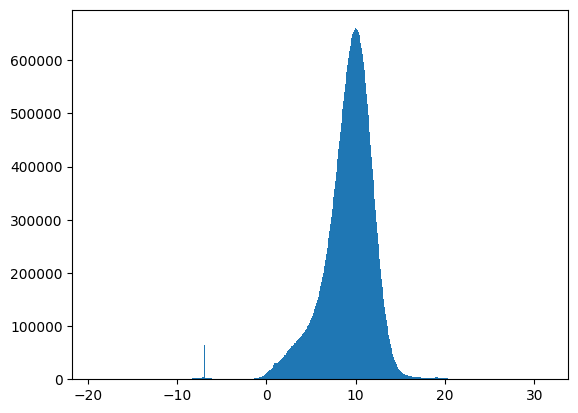

In [16]:
plot.hist(samples_cpu[:end].detach().numpy(),bins = 1000);

In [20]:
num_sim_per_event = 5.47 * 10 ** 7 / 100
dt_sim_per_event = 13
print(f"# photons per event: {num_sim_per_event}")
print(f"# photons simulated per second: {num_sim_per_event / dt_sim_per_event}")

# photons per event: 547000.0
# photons simulated per second: 42076.92307692308


In [7]:
torch.save(samples,"data/samples/July_15/Data/run_5_6_flows_4hl_100hu_4000_bs.pt")
# torch.save(eval_test_data,"data/test/July_12/run_1_8_flows_4hl_100hu_5000_bs.pt")

# samples = torch.load("data/samples/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")
# eval_test_data = torch.load("data/test/July_11/run_5_6_flows_4hl_100hu_5000_bs.pt")

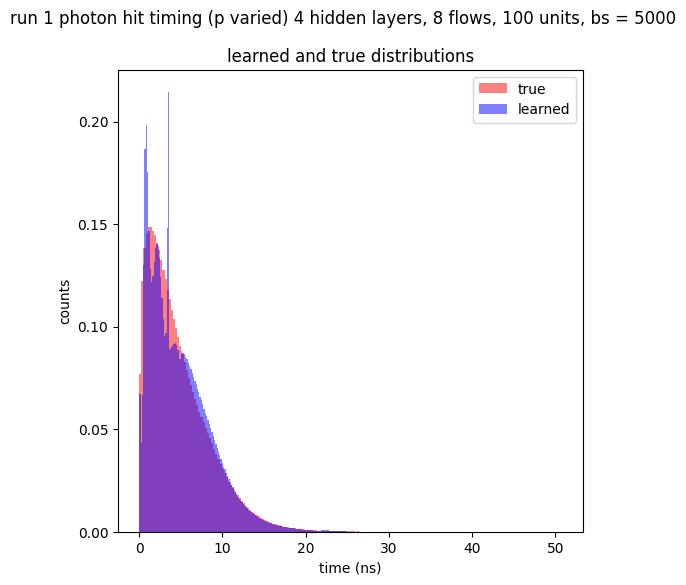

In [8]:
sample_fig, sample_axs = plot.subplots(1,1,figsize=(6,6))
sample_fig.suptitle("run 1 photon hit timing (p varied) 4 hidden layers, 8 flows, 100 units, bs = 5000")
sample_axs.hist(eval_test_data[:,num_context],bins = 200, color = 'red', alpha = 0.5, label = 'true', density = True)
sample_axs.hist(samples,bins = 200, alpha = 0.5,color = 'blue', label = 'learned', density = True)
sample_axs.set_title("learned and true distributions")
sample_axs.set_xlabel("time (ns)")
sample_axs.set_ylabel("counts")
sample_axs.legend(loc='upper right')
sample_fig.show()

In [9]:
sample_fig.savefig("plots/test_distributions/July_12/run_1_8_flows_4hl_100hu_4000bs_normalized_resample.pdf")

Multidimensional binning

In [14]:
data_tensor = eval_test_data
num_bins = 8

sample_means = np.empty((num_bins,num_bins))
data_means = np.empty((num_bins,num_bins))

# Extract the relevant features
feature1 = data_tensor[:, 0].numpy()
feature2 = data_tensor[:, 2].numpy()
target_feature = data_tensor[:, 4].numpy()

samples_np = samples.numpy()

# Calculate bin edges for feature1 and feature2
f1_bins = np.linspace(feature1.min(), feature1.max(), num_bins + 1)
f2_bins = np.linspace(feature2.min(), feature2.max(), num_bins + 1)

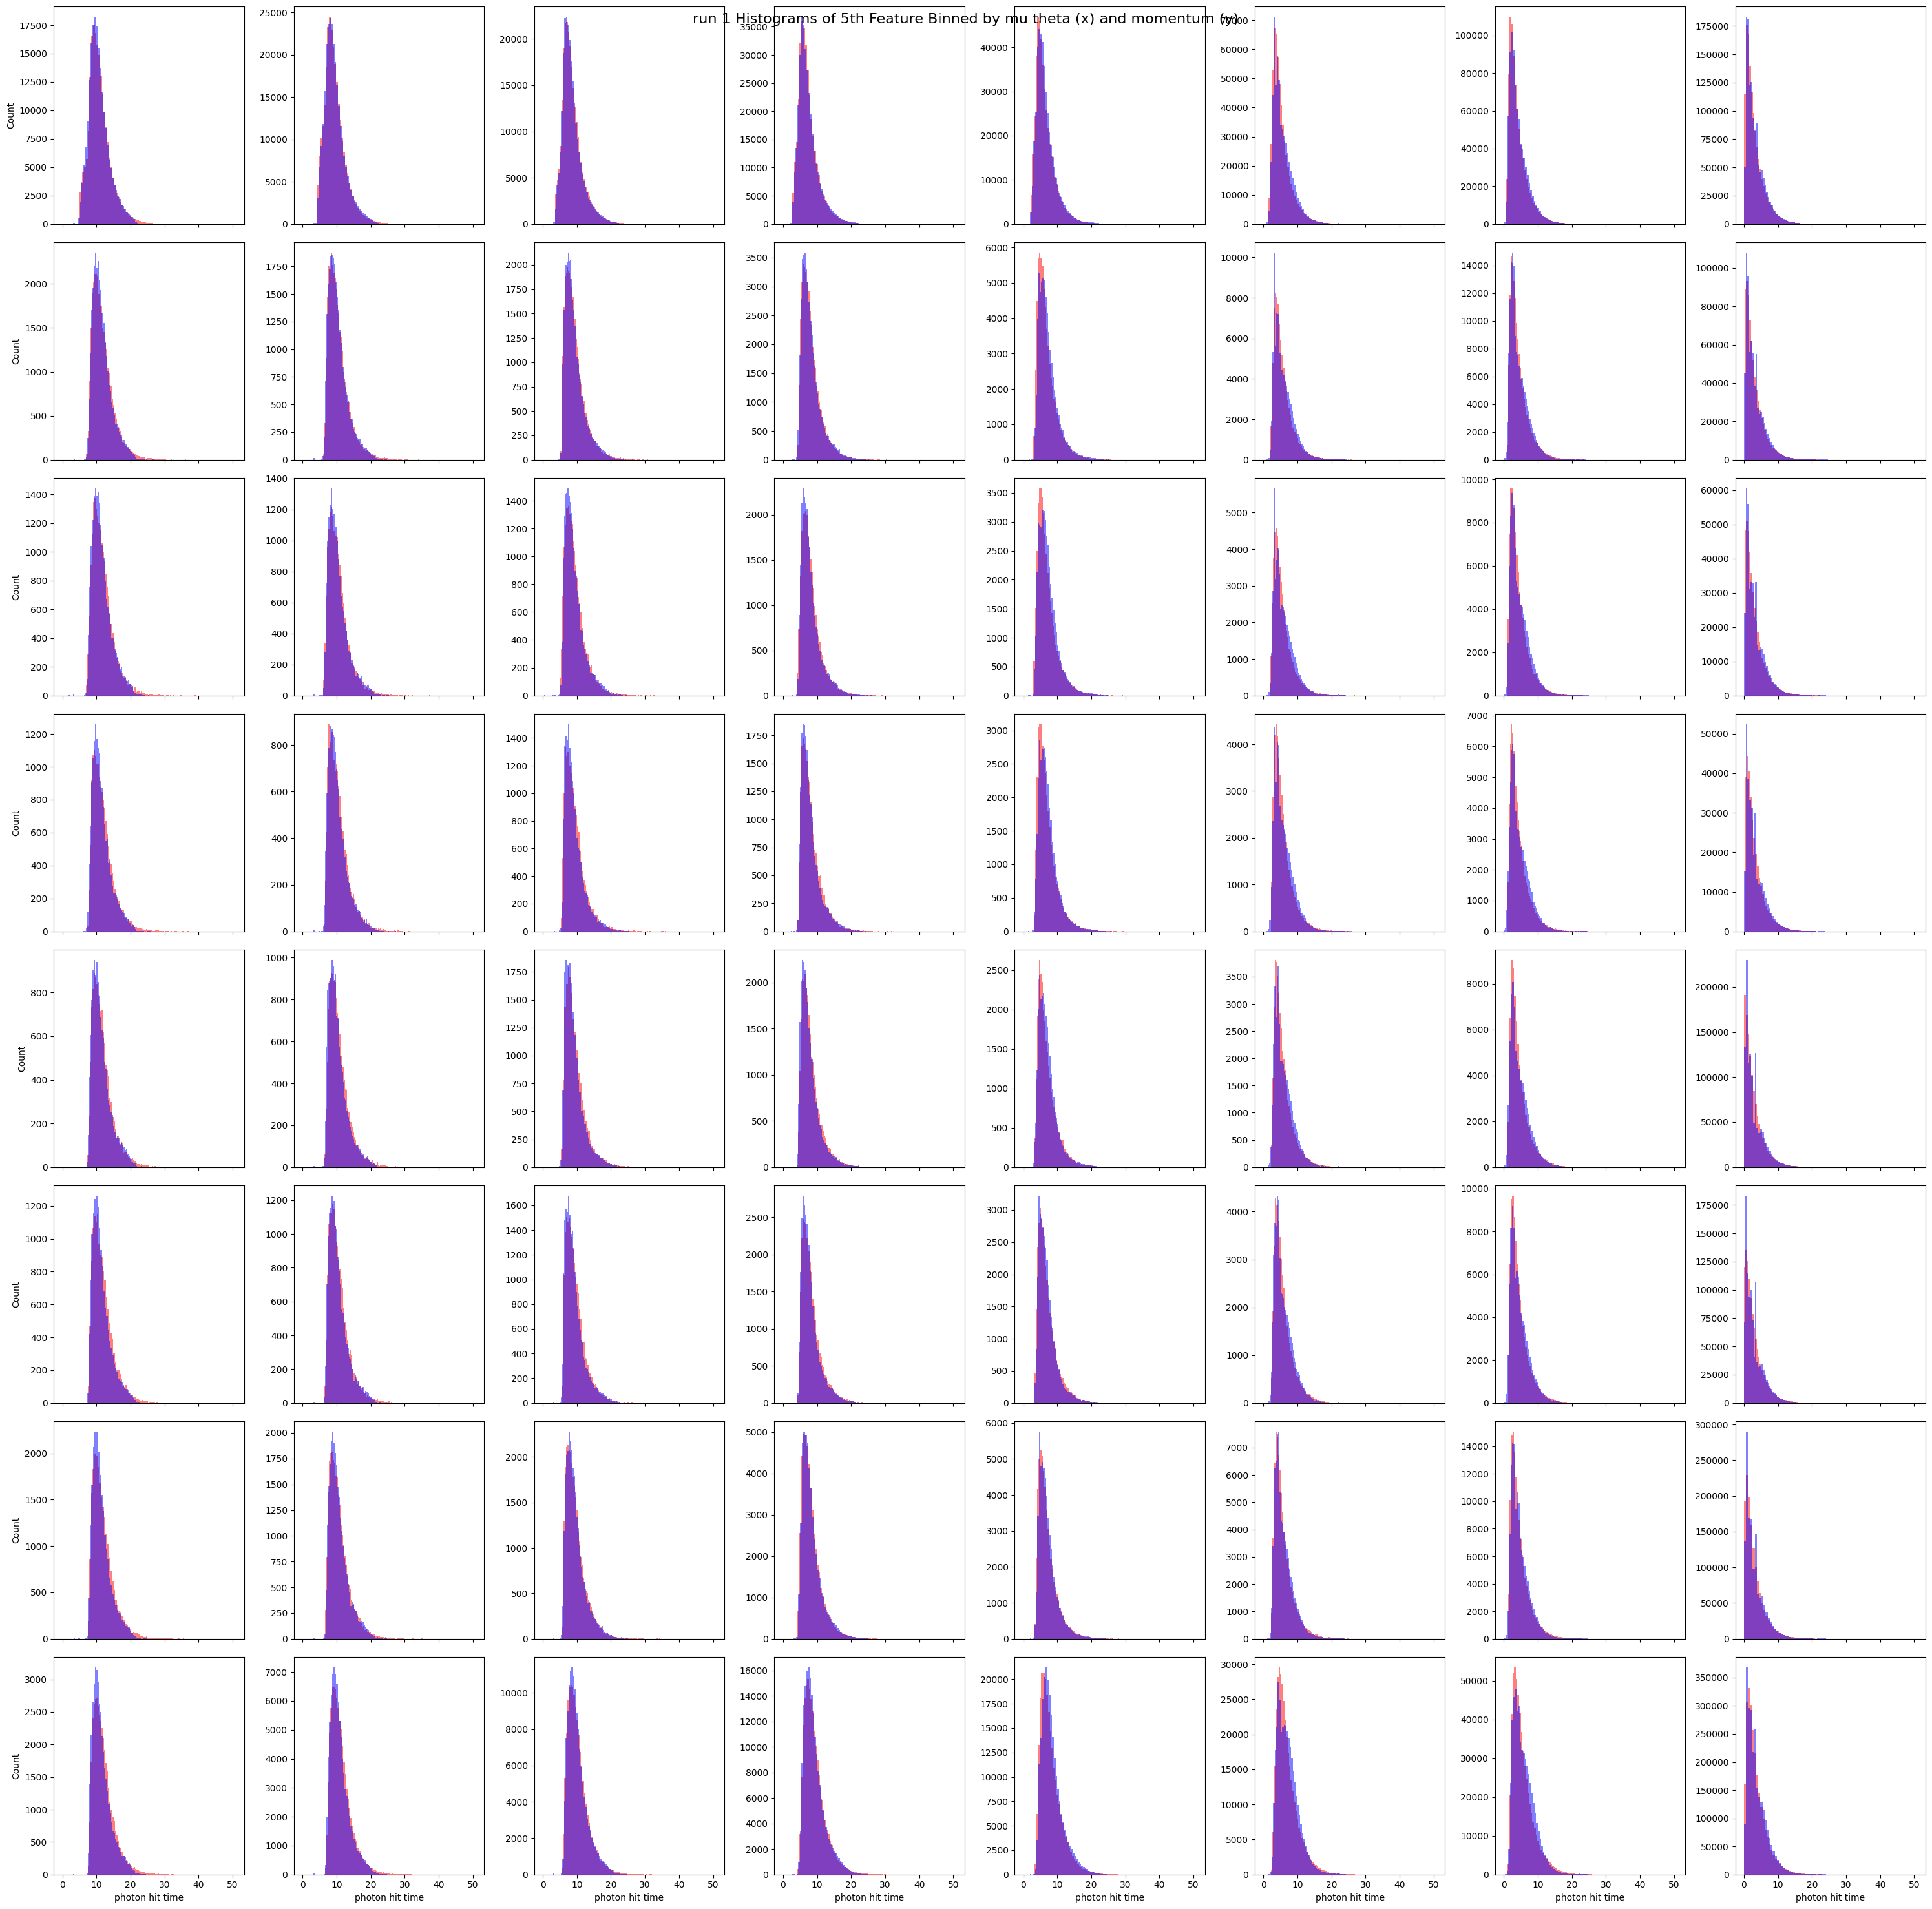

In [16]:
# Create the figure and subplots
fig, axs = plot.subplots(num_bins, num_bins, figsize=(30, 30), sharex=True)
fig.suptitle(r"run 1 Histograms of 5th Feature Binned by mu theta (x) and momentum (y)", fontsize=16)

# Iterate through the grid
for i in range(num_bins):
    for j in range(num_bins):
        # Select data points in the current bin
        mask = (
            (feature1 >= f1_bins[j]) & (feature1 < f1_bins[j+1]) &
            (feature2 >= f2_bins[i]) & (feature2 < f2_bins[i+1])
        )
        bin_data = target_feature[mask]
        bin_samples_np = samples_np[mask]
        
        sample_means[i,j] = np.mean(bin_samples_np)
        data_means[i,j] = np.mean(bin_data)
        data_max = max(bin_data)
        data_min = min(bin_data)
        
        samples_max = max(bin_samples_np)
        samples_min = min(bin_samples_np)
        
        if(samples_max - samples_min > data_max - data_min):
            n_bins_samples = 80
            bin_width = (samples_max - samples_min) / n_bins_samples
            n_bins_data = int(round((data_max - data_min) / bin_width))
        else:
            n_bins_data = 80
            bin_width = (data_max - data_min) / n_bins_data
            n_bins_samples = int(round((samples_max - samples_min) / bin_width))
        # Plot histogram in the current subplot
        axs[i, j].hist(bin_data, bins=n_bins_data, color = 'red',alpha = 0.5)
        axs[i, j].hist(bin_samples_np, bins=n_bins_samples, color = 'blue',alpha = 0.5)
#         axs[i, j].set_title(fr'Hit z pos: [{f1_bins[j]:.2f}, {f1_bins[j+1]:.2f})\n $\theta$: [{f2_bins[i]:.2f}, {f2_bins[i+1]:.2f})')

# Set labels for the outer subplots
for ax in axs[-1, :]:
    ax.set_xlabel('photon hit time')
for ax in axs[:, 0]:
    ax.set_ylabel('Count')

# Add overall x and y labels
# fig.text(0.5, 0.04, '1st Feature Bins', ha='center', va='center', fontsize=14)
# fig.text(0.06, 0.5, '2nd Feature Bins', ha='center', va='center', rotation='vertical', fontsize=14)

plot.tight_layout()
plot.show()
fig.savefig("plots/test_distributions/Binned/July_12/run_1_" + str(num_bins) + "x " + str(num_bins) + "_binned_no_normalized_z_hit_theta.pdf")
# Example usage:
# Assuming you have a PyTorch tensor named 'data_tensor' with shape [x, 5]
# create_histogram_grid(data_tensor)

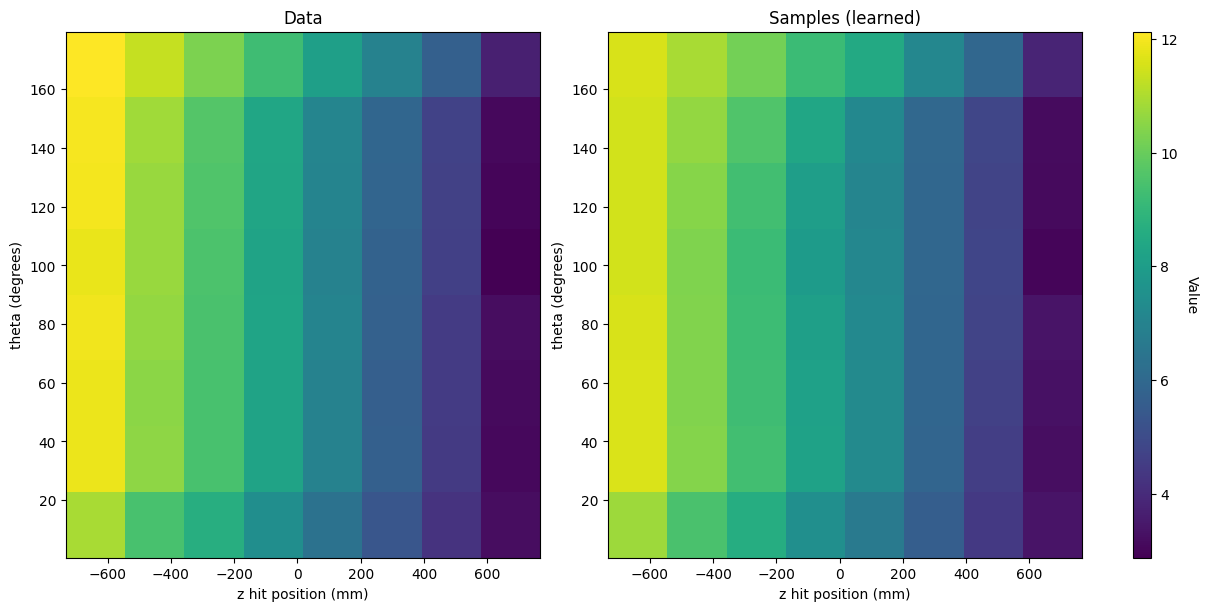

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these variables defined for both plots:
# f1_bins, f2_bins: lists or arrays of bin edges for both plots
# data_means1, data_means2: 2D arrays of values for the two plots

# Create meshgrids from the bin edges
X, Y = np.meshgrid(f1_bins[:-1] + np.diff(f1_bins)/2, 
                   f2_bins[:-1] + np.diff(f2_bins)/2)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Create the first heatmap
im1 = ax1.pcolormesh(X, Y, data_means, shading='auto', cmap='viridis')
ax1.set_xlabel('z hit position (mm)')
ax1.set_ylabel('theta (degrees)')
# ax1.set_ylabel('momentum (GeV/c)')
# ax1.set_xlabel('theta (degrees)')
ax1.set_title('Data')

# Create the second heatmap
im2 = ax2.pcolormesh(X, Y, sample_means, shading='auto', cmap='viridis')
ax2.set_xlabel('z hit position (mm)')
ax2.set_ylabel('theta (degrees)')
# ax2.set_ylabel('momentum (GeV/c)')
# ax2.set_xlabel('theta (degrees)')
ax2.set_title('Samples (learned)')

# Find the minimum and maximum of both datasets
vmin = min(data_means.min(), sample_means.min())
vmax = max(data_means.max(), sample_means.max())

# Set the color scale of both plots to the same range
im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)

# Add a colorbar that refers to both plots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', aspect=30)
cbar.set_label('Value', rotation=270, labelpad=15)

# Adjust the layout and display the plot
plt.show()
fig.savefig("plots/test_distributions/Binned/July_12/run_1_" + str(num_bins) + "x " + str(num_bins) + "_binned_means_z_theta.pdf")